In [1]:
import os
import cv2
import pandas as pd

In [2]:
from PIL import Image
def create_df(data_path):
    """
         이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    df = pd.DataFrame({})
    data_dir_list = os.listdir(data_path)
    print(data_dir_list)
    for i in range(len(data_dir_list)):
      file_list = os.listdir(data_path + "/" + data_dir_list[i])
      img_path_list = []
      for j in range(len(file_list)):
        img_path = data_path + "/" + data_dir_list[i] + "/" +file_list[j]
        try:
          image = Image.open(img_path)
          image.verify()
          img_path_list.append(img_path)
        except:
          print(img_path)
          pass
      df = pd.concat([df,pd.DataFrame({'File_path':img_path_list,'Label':data_dir_list[i]})])
      print(data_dir_list[i],len(file_list))

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return df

In [3]:
df = create_df('dataset/train')

['hh', 'cse', 'wb', 'wjj', 'rg']
hh 752
cse 1159
wb 1028
wjj 1053
rg 1036


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=0, stratify=df.Label)
print(train_df.shape, val_df.shape)

(4525, 2) (503, 2)


In [5]:
test_df = create_df('dataset/test')

['hh', 'cse', 'wb', 'wjj', 'rg']
hh 88
cse 126
wb 113
wjj 124
rg 113


In [6]:
import numpy as np
import tensorflow as tf

def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    val_images = val_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator, train_images, val_images, test_images

2024-12-06 13:47:52.117919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733460472.129137 2136575 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733460472.132570 2136575 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 13:47:52.144761: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
train_generator,val_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 4525 validated image filenames belonging to 5 classes.
Found 503 validated image filenames belonging to 5 classes.
Found 564 validated image filenames belonging to 5 classes.


In [7]:
import time
import tensorflow as tf

models = {
    # "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    # "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    # "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    # "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    # "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    # "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,val_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(150, 150, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    # 라벨 개수가 5개이기 때문에 Dencs도 5로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = time.perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,validation_steps=5,epochs=1,verbose=1)
    
    # 학습시간과 val_accuracy 저장
    duration = time.perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 4525 validated image filenames belonging to 5 classes.
Found 503 validated image filenames belonging to 5 classes.


Found 564 validated image filenames belonging to 5 classes.




I0000 00:00:1733458918.845889 2100568 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20672 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


/home/team105/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733458941.887371 2101006 service.cc:148] XLA service 0x7efe600b7030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733458941.887447 2101006 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-12-06 13:22:22.229284: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733458944.268318 2101006 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-06 13:22:25.332137: I external

 2/71 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.2852 - loss: 1.8179  

I0000 00:00:1733458949.866318 2101006 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/71 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.4833 - loss: 1.2395

2024-12-06 13:22:47.977817: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14461_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:22:48.092697: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14461_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:22:48.102739: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14728', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:22:48.153980: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14461', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:22:48.154741: I external/local_xla/xla/stream_

71/71 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7116 - loss: 0.7127 - val_accuracy: 0.9250 - val_loss: 0.2176
ResNet152V2          trained in 120.1 sec
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.2685 - loss: 1.5885 - val_accuracy: 0.3844 - val_loss: 1.4265
ResNet50             trained in 100.88 sec
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7594 - loss: 0.6136 - val_accuracy: 0.9438 - val_loss: 0.1986
ResNet50V2           trained in 99.43 sec
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


2024-12-06 13:27:47.091315: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1295', 440 bytes spill stores, 440 bytes spill loads

2024-12-06 13:27:47.097197: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1295', 496 bytes spill stores, 496 bytes spill loads



68/71 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5768 - loss: 1.2383

2024-12-06 13:29:08.647884: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_761', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:29:08.693566: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1295', 12 bytes spill stores, 12 bytes spill loads

2024-12-06 13:29:08.768154: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1295', 68 bytes spill stores, 68 bytes spill loads

2024-12-06 13:29:08.776058: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1295', 68 bytes spill stores, 68 bytes spill loads

2024-12-06 13:29:08.827664: I external/local_xla/xla/stream_exe

71/71 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5835 - loss: 1.2217 - val_accuracy: 0.8156 - val_loss: 0.5428
VGG19                trained in 99.36 sec
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5339 - loss: 1.1910 - val_accuracy: 0.8094 - val_loss: 0.5173
VGG16                trained in 94.41 sec


In [8]:
# test데이터로 모델 성능 예측
from sklearn.metrics import accuracy_score
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['accuracy'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['accuracy'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

8/9 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   

2024-12-06 13:32:09.964545: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4413', 4 bytes spill stores, 4 bytes spill loads

2024-12-06 13:32:09.996798: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4413_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:32:10.063316: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4413', 224 bytes spill stores, 224 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
**ResNet152V2 has a 91.13% accuracy on the test set**
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 
**ResNet50 has a 39.54% accuracy on the test set**
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
**ResNet50V2 has a 93.26% accuracy on the test set**
8/9 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

2024-12-06 13:33:00.018043: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_216', 4 bytes spill stores, 4 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
**VGG19 has a 83.33% accuracy on the test set**
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
**VGG16 has a 84.57% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,ResNet50V2,0.9438,0.9326,99.43
1,ResNet152V2,0.9250,0.9113,120.10
2,VGG16,0.8094,0.8457,94.41
3,VGG19,0.8156,0.8333,99.36
4,ResNet50,0.3844,0.3954,100.88


In [8]:
import random

"""
랜덤 시드 고정
"""
def fix_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
"""
모델링
"""
def get_model(model):
    # Load the pretained model
    kwargs =    {'input_shape':(150, 150, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False# 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    tuning_layer_name = 'conv5_block1_preact_bn'
    tuning_layer = pretrained_model.get_layer(tuning_layer_name)
    tuning_index = pretrained_model.layers.index(tuning_layer)

    for layer in pretrained_model.layers[tuning_index:]:
        layer.trainable = True
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Flatten()(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    # 라벨 개수가 5개이기 때문에 Dencs도 5로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/epoch-{epoch}-val_loss-{val_loss:.4f}-val_acc-{val_accuracy:.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)
fix_seed(0)
model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=10,verbose=1,callbacks=[model_checkpoint])

I0000 00:00:1733460482.915009 2136575 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18942 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6
/home/team105/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1733460494.102089 2137182 service.cc:148] XLA service 0x7f36100019b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733460494.102134 2137182 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-12-06 13:48:14.266948: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733460495.276269 2137182 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/71 ━━━━━━━━━━━━━━━━━━━━ 17:11 15s/step - accuracy: 0.2188 - loss: 2.3873

I0000 00:00:1733460501.464697 2137182 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8101 - loss: 0.5394

2024-12-06 13:49:51.233449: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1541', 192 bytes spill stores, 512 bytes spill loads

2024-12-06 13:49:59.355879: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1541_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:49:59.358733: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1541', 4 bytes spill stores, 4 bytes spill loads

2024-12-06 13:49:59.549740: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1541', 224 bytes spill stores, 224 bytes spill loads




Epoch 1: val_loss improved from inf to 0.66847, saving model to ./checkpoints/epoch-1-val_loss-0.6685-val_acc-0.8767.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.8114 - loss: 0.5359 - val_accuracy: 0.8767 - val_loss: 0.6685
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9788 - loss: 0.0857
Epoch 2: val_loss improved from 0.66847 to 0.15103, saving model to ./checkpoints/epoch-2-val_loss-0.1510-val_acc-0.9642.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9787 - loss: 0.0857 - val_accuracy: 0.9642 - val_loss: 0.1510
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9793 - loss: 0.0659
Epoch 3: val_loss did not improve from 0.15103
71/71 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9794 - loss: 0.0658 - val_accuracy: 0.9384 - val_loss: 0.3081
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9872 - loss: 0.0384
Epoch 4: val_loss improved from 0.15103 to 0.10575, saving model to ./checkpoints/epoch-4-val_loss-0.1057-v

KeyboardInterrupt: 

In [9]:
from sklearn.metrics import accuracy_score
from keras.models import load_model

model = load_model('./checkpoints/epoch-4-val_loss-0.1057-val_acc-0.9682.keras')
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'# Accuracy on the test set: {acc * 100:.2f}%')

/home/team105/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/9 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   

2024-12-06 13:56:31.477270: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512', 4 bytes spill stores, 4 bytes spill loads

2024-12-06 13:56:31.480090: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:56:31.631828: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512', 224 bytes spill stores, 224 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
# Accuracy on the test set: 95.39%


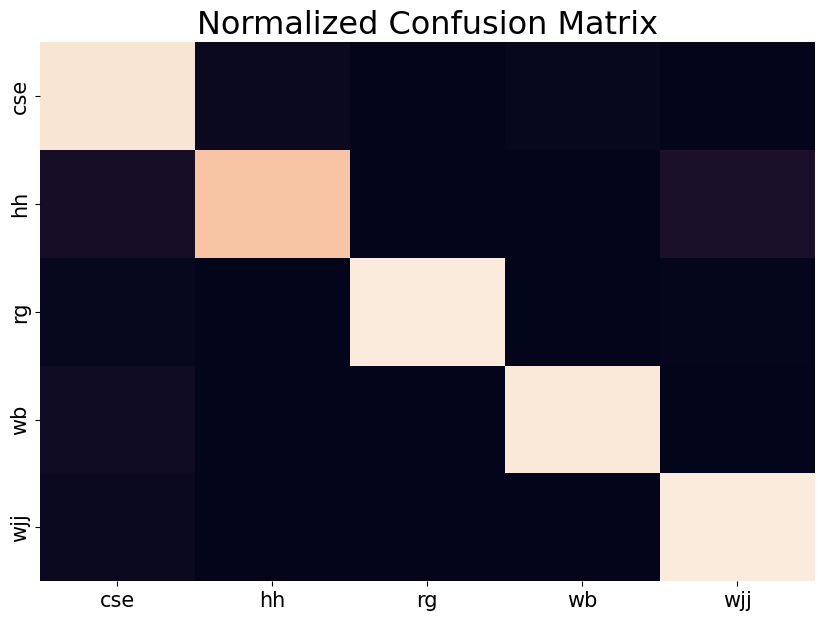

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [17]:
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.applications.resnet_v2 import preprocess_input

def printmd(string):
    display(string)
class_dictionary = test_images.class_indices
#model = load_model('F:/PDC_2022/PDC_2022/track1/submission/augmentaion_TL_ResNet50V2.h5')
IMAGE_SIZE    = (150, 150)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


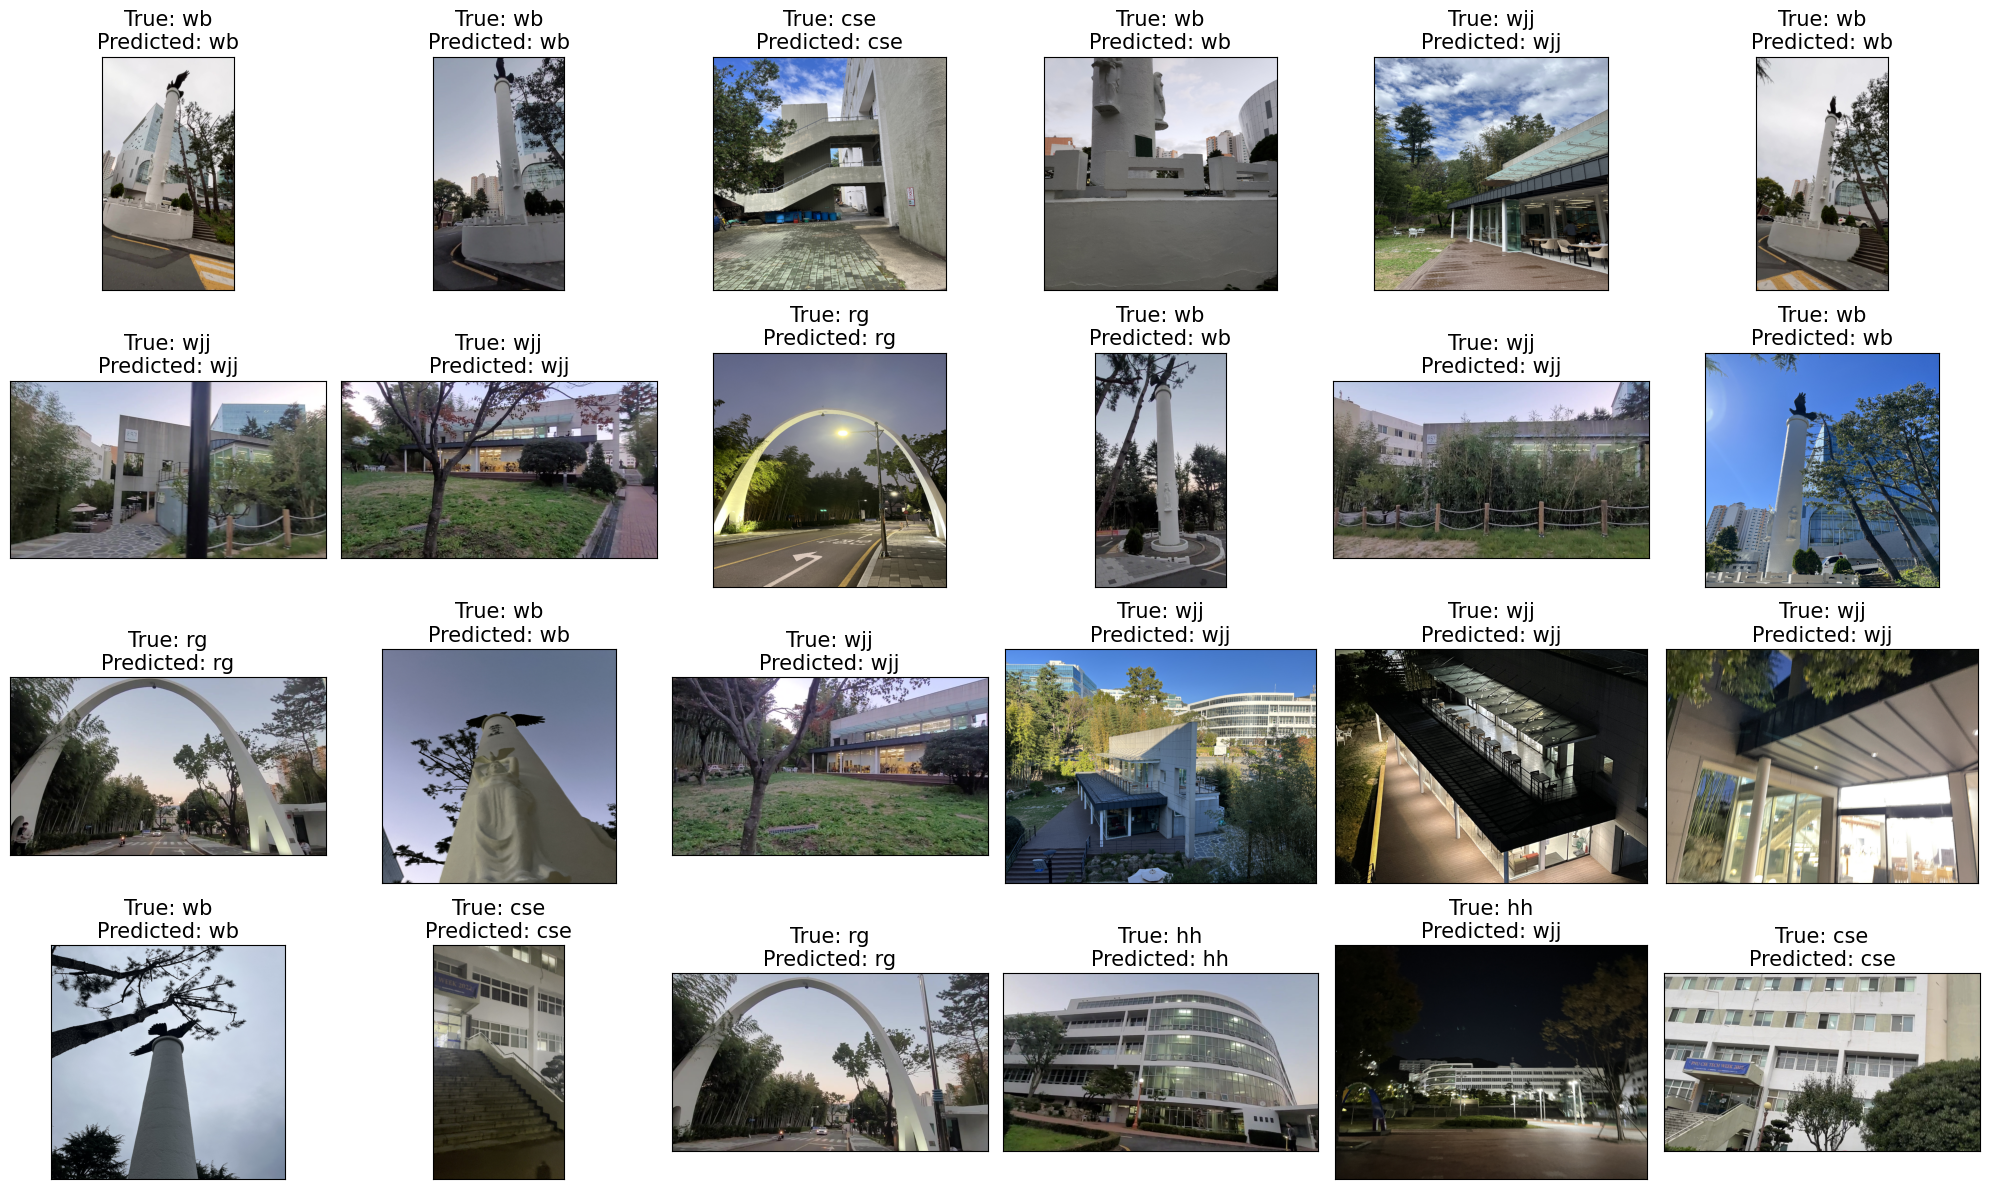

In [18]:
from keras.preprocessing import image

#여러 이미지 테스트
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.File_path.iloc[i]))
    test_image = image.load_img(test_df.iloc[i, 0]
                            ,target_size =IMAGE_SIZE )
    test_image = image.img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    test_image = preprocess_input(test_image)
    prediction = model.predict(test_image)
    df = pd.DataFrame({'pred':prediction[0]})
    df = df.sort_values(by='pred', ascending=False, na_position='first')
    for x in class_dictionary:
      if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
        ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {x}", fontsize = 15)
plt.tight_layout()
plt.show()